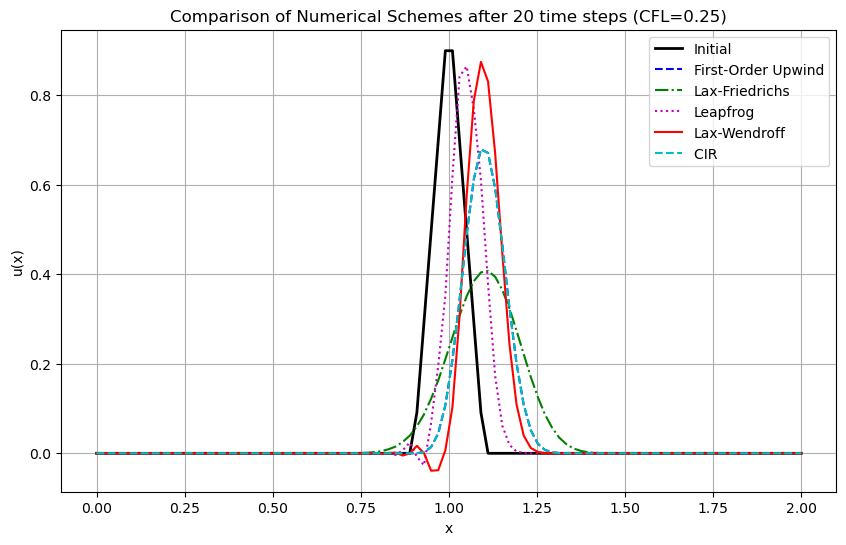


Error norms comparison:
Scheme          L1         L2         Linf      
FOU             1.348e-02  4.223e-02  2.282e-01 
Lax-Friedrichs  3.752e-02  9.913e-02  4.950e-01 
Leapfrog        4.334e-02  1.338e-01  5.485e-01 
Lax-Wendroff    5.965e-03  1.761e-02  9.005e-02 
CIR             1.348e-02  4.223e-02  2.282e-01 


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
a = 1.0
x_min, x_max = 0.0, 2.0
nx = 100
dx = (x_max - x_min) / (nx - 1)
CFL = 0.25
dt = CFL * dx / a
nt = 20

# Spatial grid
x = np.linspace(x_min, x_max, nx)

# Initial condition
def initial_condition(x):
    u = np.zeros_like(x)
    mask1 = (x >= 0.9) & (x <= 1.0)
    mask2 = (x >= 1.0) & (x <= 1.1)
    u[mask1] = 10.0 * (x[mask1] - 0.9)
    u[mask2] = 10.0 * (1.1 - x[mask2])
    return u

u_initial = initial_condition(x)

# First-Order Upwind
def fou_scheme(u, nt, dt, dx, a):
    u = u.copy()
    for _ in range(nt):
        u[1:] = u[1:] - (a * dt / dx) * (u[1:] - u[:-1])
        u[0] = u[-1]      # periodic left boundary
    return u

# Lax-Friedrichs
def lax_friedrichs(u, nt, dt, dx, a):
    u = u.copy()
    for _ in range(nt):
        u[1:-1] = 0.5 * (u[2:] + u[:-2]) - (a * dt / (2.0 * dx)) * (u[2:] - u[:-2])
        u[0] = u[-2]     # periodic
        u[-1] = u[1]
    return u

# Leapfrog (corrected)
def leapfrog(u, nt, dt, dx, a):
    u_prev = u.copy()
    u_curr = u_prev.copy()
    # first step with upwind
    u_curr[1:] = u_prev[1:] - (a * dt / dx) * (u_prev[1:] - u_prev[:-1])
    u_curr[0] = u_prev[-1]
    for _ in range(1, nt):
        u_next = np.empty_like(u_curr)
        u_next[1:-1] = u_prev[1:-1] - (a * dt / (2.0 * dx)) * (u_curr[2:] - u_curr[:-2])
        u_next[0] = u_prev[-1]
        u_next[-1] = u_prev[1]
        u_prev, u_curr = u_curr, u_next
    return u_curr

# Lax-Wendroff
def lax_wendroff(u, nt, dt, dx, a):
    u = u.copy()
    sigma = a * dt / dx
    for _ in range(nt):
        u[1:-1] = (u[1:-1] 
                   - 0.5 * sigma * (u[2:] - u[:-2])
                   + 0.5 * sigma**2 * (u[2:] - 2.0 * u[1:-1] + u[:-2]))
        u[0] = u[-2]
        u[-1] = u[1]
    return u

def cir_scheme(u, nt, dt, dx, a):
    u = u.copy()
    nx = len(u)
    for _ in range(nt):
        F = np.zeros(nx + 1)  # fluxes at interfaces i+1/2
        u_padded = np.zeros(nx + 2)  # padded for periodicity
        u_padded[1:-1] = u
        u_padded[0] = u[-1]  # periodic left
        u_padded[-1] = u[0]  # periodic right

        if a > 0:
            F[:] = a * u_padded[:-1]
        else:
            F[:] = a * u_padded[1:]

        u -= (dt / dx) * (F[1:] - F[:-1])
    return u



# Solve with all schemes
u_fou = fou_scheme(u_initial, nt, dt, dx, a)
u_lf = lax_friedrichs(u_initial, nt, dt, dx, a)
u_leapfrog = leapfrog(u_initial, nt, dt, dx, a)
u_lw = lax_wendroff(u_initial, nt, dt, dx, a)
u_cir = cir_scheme(u_initial, nt, dt, dx, a)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x, u_initial, 'k-', linewidth=2, label='Initial')
plt.plot(x, u_fou, 'b--', label='First-Order Upwind')
plt.plot(x, u_lf, 'g-.', label='Lax-Friedrichs')
plt.plot(x, u_leapfrog, 'm:', label='Leapfrog')
plt.plot(x, u_lw, 'r-', label='Lax-Wendroff')
plt.plot(x, u_cir, 'c--', label='CIR  ')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title(f'Comparison of Numerical Schemes after {nt} time steps (CFL={CFL})')
plt.legend()
plt.grid(True)
plt.show()

# Calculate error norms
def calculate_errors(u_num, u_exact):
    L1 = np.mean(np.abs(u_num - u_exact))
    L2 = np.sqrt(np.mean((u_num - u_exact)**2))
    Linf = np.max(np.abs(u_num - u_exact))
    return L1, L2, Linf

# Exact solution (shifted by a*nt*dt)
shift = int(a * nt * dt / dx)
u_exact = np.roll(u_initial, shift)

# Calculate errors for each scheme
errors = {
    'FOU': calculate_errors(u_fou, u_exact),
    'Lax-Friedrichs': calculate_errors(u_lf, u_exact),
    'Leapfrog': calculate_errors(u_leapfrog, u_exact),
    'Lax-Wendroff': calculate_errors(u_lw, u_exact),
    'CIR': calculate_errors(u_cir, u_exact)
}

# Print error table
print("\nError norms comparison:")
print("{:<15} {:<10} {:<10} {:<10}".format("Scheme", "L1", "L2", "Linf"))
for scheme, (L1, L2, Linf) in errors.items():
    print("{:<15} {:<10.3e} {:<10.3e} {:<10.3e}".format(scheme, L1, L2, Linf))